Import libraries & initial set up

In [1]:
import os
import shutil
import random
import pandas as pd
import spyder

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth

In [3]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [5]:
# Settings for displaying charts
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

In [6]:
# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
img_size = 150
batch_size = 32

Prepare data

In [7]:
# Path to the folder with 6 classes of images:
data_path = 'deep_mushroom'
os.chdir(data_path)

In [8]:
# Create train, valid and test folders
os.mkdir('train')
os.mkdir('valid')
os.mkdir('test')

# Add subfolders with mushrooms genuses in train, valid and test folders
for subfolder in os.listdir():
    if subfolder not in ('train','valid','test'):
        os.mkdir(f'train/{subfolder}')
        os.mkdir(f'valid/{subfolder}')
        os.mkdir(f'test/{subfolder}')

In [9]:
# Count items in each folder
for subfolder in os.listdir():

    # Making a list of all files in current subfolder:
     if subfolder not in ('train','valid','test'):

        # Making a list of all files in current subfolder:
        original_path = f'{subfolder}'
        original_data = os.listdir(original_path)
        n_samples = len(original_data)
        print(f'Photos in {original_path}: {n_samples}')

# In russula folder there are 2x more photos than in the other folders.
# We would need to drop half of photos from russula folder to keep each class at similar level.

Photos in agaricus: 400
Photos in amanita: 610
Photos in boletus: 387
Photos in hygrocybe: 615
Photos in leccinum: 419
Photos in russula: 1157


In [10]:
# Copy existing photos - randomly split to train/validation/test folders (75%/15%/10%)
for subfolder in os.listdir():

    # Making a list of all files in current subfolder:
     if subfolder not in ('train','valid','test'):

        # Making a list of all files in current subfolder:
        original_path = f'{subfolder}'
        original_data = os.listdir(original_path)

        # Train, validation and testing folders
        train_path = f'train/{subfolder}'
        valid_path = f'valid/{subfolder}'
        test_path = f'test/{subfolder}'

        # Random indices split
        # For russula genus (use have of images):
        if subfolder == 'russula':
            # Number of samples in each group:
            n_samples = len(original_data)//2
            train_samples = int(n_samples * 0.75)
            valid_samples = int(n_samples * 0.9)

            idx_list = list(n for n in range(0,n_samples))
            random.shuffle(idx_list)
            # Indices lists
            train_idx = idx_list[0:train_samples]
            valid_idx = idx_list[train_samples:valid_samples]
            test_idx = idx_list[valid_samples:n_samples]

        else:
            # Number of samples in each group:
            n_samples = len(original_data)
            train_samples = int(n_samples * 0.75)
            valid_samples = int(n_samples * 0.9)

            idx_list = list(n for n in range(0,n_samples))
            random.shuffle(idx_list)

            # Indices lists
            train_idx = idx_list[0:train_samples]
            valid_idx = idx_list[train_samples:valid_samples]
            test_idx = idx_list[valid_samples:n_samples]

        # Copy image to proper folder based on index
        for image in range(n_samples):
            original_file = f'{original_path}/{original_data[image]}'
            if image in train_idx:
                new_file = f'{train_path}/{original_data[image]}'
                shutil.copyfile(original_file, new_file)
            if image in valid_idx:
                new_file = f'{valid_path}/{original_data[image]}'
                shutil.copyfile(original_file, new_file)
            if image in test_idx:
                new_file = f'{test_path}/{original_data[image]}'
                shutil.copyfile(original_file, new_file)

        print(f'Starting with {subfolder}, total number of photos copied: {n_samples}.')
        print(f'{len(train_idx)} photos copied to {train_path}.')
        print(f'{len(valid_idx)} photos copied to {valid_path}.')
        print(f'{len(test_idx)} photos copied to {test_path}.')

Starting with agaricus, total number of photos copied: 400.
300 photos copied to train/agaricus.
60 photos copied to valid/agaricus.
40 photos copied to test/agaricus.
Starting with amanita, total number of photos copied: 610.
457 photos copied to train/amanita.
92 photos copied to valid/amanita.
61 photos copied to test/amanita.
Starting with boletus, total number of photos copied: 387.
290 photos copied to train/boletus.
58 photos copied to valid/boletus.
39 photos copied to test/boletus.
Starting with hygrocybe, total number of photos copied: 615.
461 photos copied to train/hygrocybe.
92 photos copied to valid/hygrocybe.
62 photos copied to test/hygrocybe.
Starting with leccinum, total number of photos copied: 419.
314 photos copied to train/leccinum.
63 photos copied to valid/leccinum.
42 photos copied to test/leccinum.
Starting with russula, total number of photos copied: 578.
433 photos copied to train/russula.
87 photos copied to valid/russula.
58 photos copied to test/russula.


Display images examples

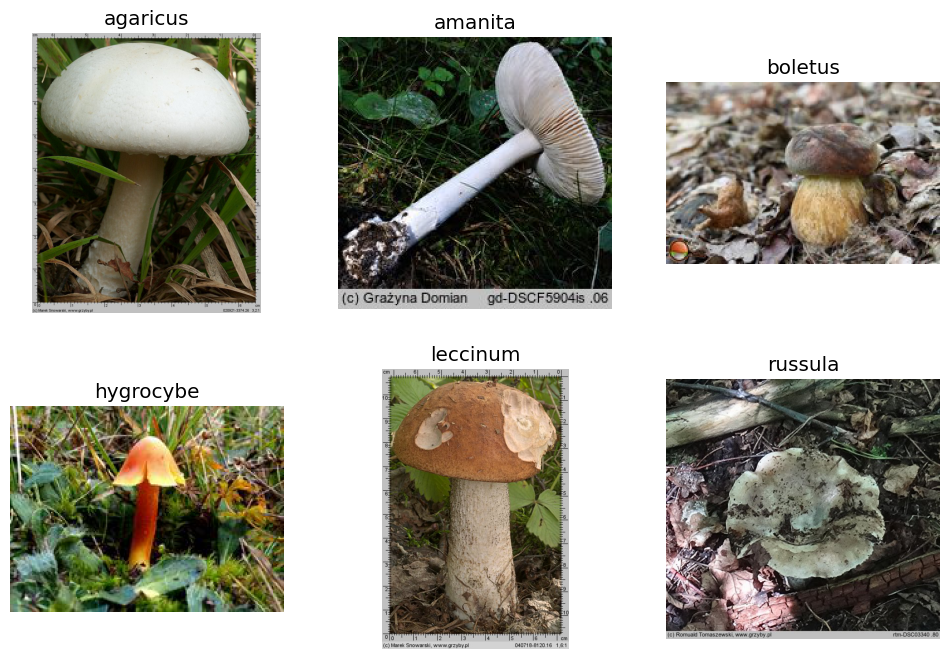

In [20]:
nrows = 2
ncols = 3

for i, subfolder in enumerate(os.listdir()):
    if i >= nrows * ncols:
        break

    image_file = os.listdir(subfolder)[0]

    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos = i + 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

Create image datasets

In [12]:
train_generator = ImageDataGenerator(preprocessing_function = preprocess_input)\
                    .flow_from_directory(directory = 'train',
                                         target_size = (img_size, img_size),
                                         class_mode = 'categorical',
                                         batch_size = batch_size,
                                         shuffle = True)
valid_generator = ImageDataGenerator(preprocessing_function = preprocess_input)\
                    .flow_from_directory(directory = 'valid',
                                         target_size = (img_size, img_size),
                                         class_mode = 'categorical',
                                         batch_size = batch_size,
                                         shuffle = True)
test_generator = ImageDataGenerator(preprocessing_function = preprocess_input)\
                    .flow_from_directory(directory = 'test',
                                         target_size = (img_size, img_size),
                                         class_mode = 'categorical',
                                         batch_size = batch_size,
                                         shuffle = True)

Found 2255 images belonging to 6 classes.
Found 452 images belonging to 6 classes.
Found 302 images belonging to 6 classes.


Creating model

In [13]:
# Pretrained EfficientNetB7 image classification model without final layers
feature_model = tf.keras.applications.EfficientNetB7(weights = 'imagenet',
                                                     include_top = False,
                                                     input_shape = (img_size, img_size, 3),
                                                     pooling = 'avg')

feature_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0

In [14]:
# Construct a new model with the final dense layer for 6 classes
new_model = tf.keras.models.Sequential(
    [
        feature_model,
        tf.keras.layers.Dense(6, activation = 'softmax')
    ]
)

In [15]:
# Make all the layers from the original ResNet model untrainable
new_model.layers[0].trainable = False

In [16]:
# Check the architecture of the new model
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 dense (Dense)               (None, 6)                 15366     
                                                                 
Total params: 64,113,053
Trainable params: 15,366
Non-trainable params: 64,097,687
_________________________________________________________________


In [17]:
# Callbacks to be exercised during training
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                              patience = 10,
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.1,
                                                 mode = 'max',
                                                 cooldown = 2,
                                                 patience = 2,
                                                 min_lr = 0)

In [18]:
# Compile model
new_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

In [19]:
# Train new model:
history = new_model.fit(train_generator,
                        validation_data = valid_generator,
                        epochs = 50,
                        steps_per_epoch = train_generator.n/batch_size,
                        validation_steps = valid_generator.n/batch_size,
                        verbose = 2,
                        callbacks = [reduce_lr, early_stop])

Epoch 1/50
70/70 - 206s - loss: 1.3264 - accuracy: 0.5100 - val_loss: 1.0971 - val_accuracy: 0.6106 - lr: 0.0010 - 206s/epoch - 3s/step
Epoch 2/50
70/70 - 167s - loss: 0.9688 - accuracy: 0.6674 - val_loss: 0.9990 - val_accuracy: 0.6438 - lr: 0.0010 - 167s/epoch - 2s/step
Epoch 3/50
70/70 - 159s - loss: 0.8510 - accuracy: 0.7060 - val_loss: 0.9329 - val_accuracy: 0.6372 - lr: 0.0010 - 159s/epoch - 2s/step
Epoch 4/50
70/70 - 170s - loss: 0.7737 - accuracy: 0.7330 - val_loss: 0.8864 - val_accuracy: 0.6681 - lr: 0.0010 - 170s/epoch - 2s/step
Epoch 5/50
70/70 - 158s - loss: 0.7131 - accuracy: 0.7667 - val_loss: 0.8623 - val_accuracy: 0.6637 - lr: 0.0010 - 158s/epoch - 2s/step
Epoch 6/50
70/70 - 160s - loss: 0.6691 - accuracy: 0.7796 - val_loss: 0.8341 - val_accuracy: 0.6792 - lr: 0.0010 - 160s/epoch - 2s/step
Epoch 7/50
70/70 - 163s - loss: 0.6318 - accuracy: 0.7885 - val_loss: 0.8170 - val_accuracy: 0.6726 - lr: 0.0010 - 163s/epoch - 2s/step
Epoch 8/50
70/70 - 173s - loss: 0.5890 - accurac

In [21]:
loss, accuracy = new_model.evaluate(test_generator,
                                    steps = test_generator.n/batch_size,
                                    verbose = 2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

9/9 - 18s - loss: 0.7786 - accuracy: 0.7252 - 18s/epoch - 2s/step
Model performance on test images:
Accuracy = 0.7251655459403992
Loss = 0.7785993814468384


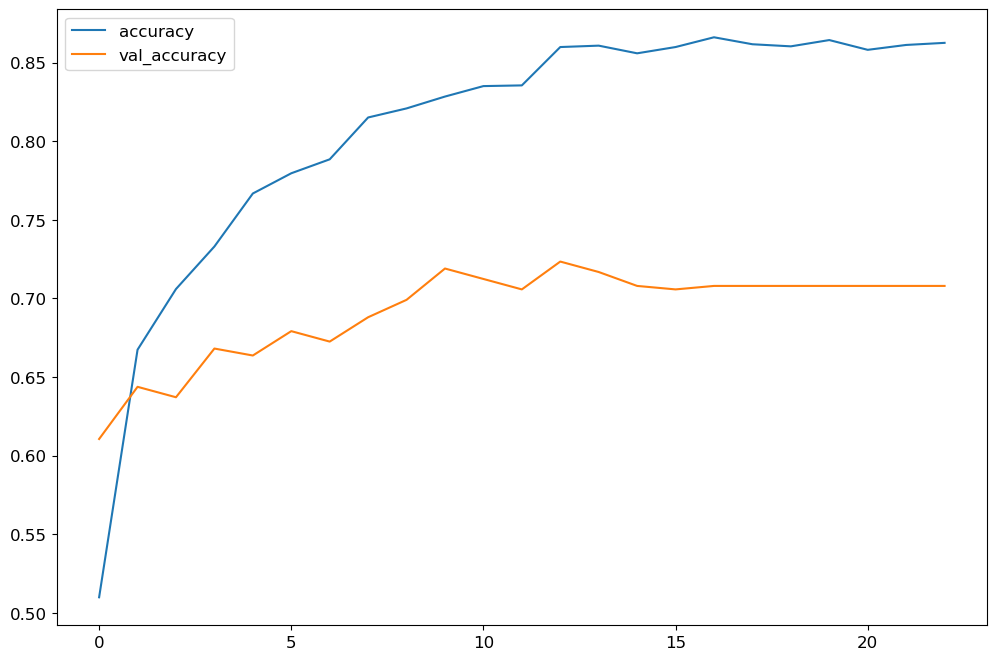

In [23]:
# Accuracy during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

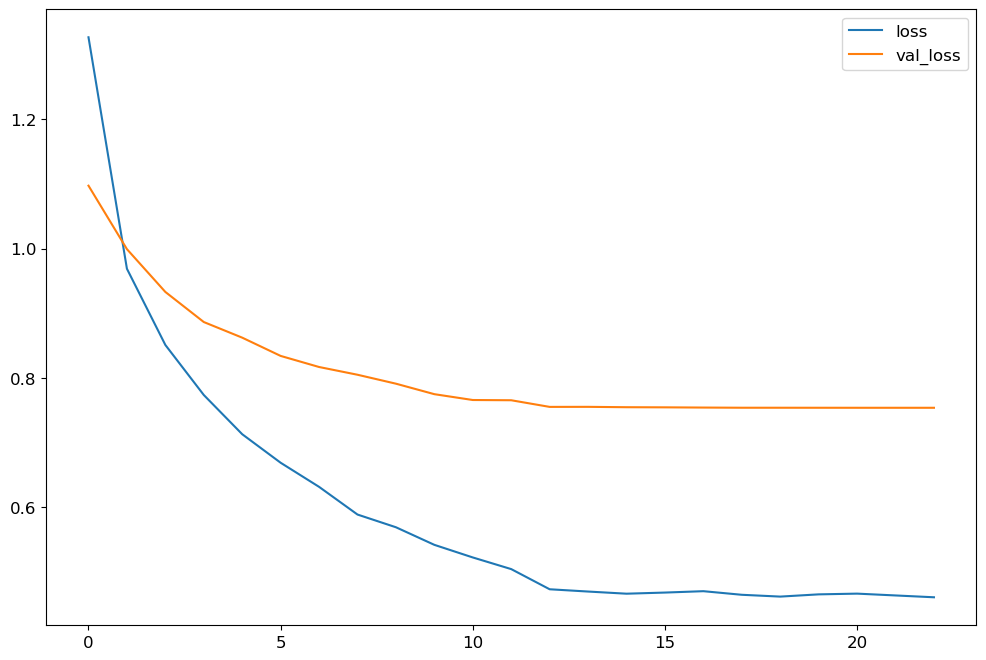

In [24]:
# Loss
history_frame.loc[:, ['loss', 'val_loss']].plot();